# AEBS
Demonstration of `AEJxLPL_2F` and `AEJxPBL_2F` products.

In [4]:
from viresclient import SwarmRequest
from viresclient._wps.time_util import parse_datetime

SPACECRAFT = "A"
TIME = "2015-06-02T00:00:00Z"

try:
    request = SwarmRequest("https://staging.viresdisc.vires.services/ows")

    orbit_number = request.get_orbit_number(SPACECRAFT, parse_datetime(TIME))
    start_time, end_time =  request.get_times_for_orbits(SPACECRAFT, orbit_number, orbit_number)
    print("Orbit number: %s:%s" % (SPACECRAFT, orbit_number))
    print("Start time:  ", start_time)
    print("End time:    ", end_time)
    
    # retrieve latitude profiles
    request.set_collection("SW_OPER_AEJ%sLPL_2F" % SPACECRAFT)
    request.set_products(
        measurements=['Latitude_QD', 'Longitude_QD', 'MLT_QD', 'J', 'J_QD'],
        auxiliaries=['QDOrbitDirection', 'OrbitNumber'],
        sampling_step="PT1S",       # 1 second sampling
    )
    response = request.get_between(
        start_time=start_time,
        end_time=end_time,
    )
    print("Sources:\n\t%s" % "\n\t".join(response.sources))
    profile = response.as_xarray()
    
    # retrieve peeks and boundaries
    request.set_collection("SW_OPER_AEJ%sPBL_2F" % SPACECRAFT)
    request.set_products(
        measurements=['Latitude_QD', 'Longitude_QD', 'MLT_QD', 'J_QD', 'Flags', 'PointType'],
        auxiliaries=['QDOrbitDirection', 'OrbitNumber'],
        sampling_step="PT1S",       # 1 second sampling
    )
    response = request.get_between(
        start_time=start_time,
        end_time=end_time,
    )
    print("Sources:\n\t%s" % "\n\t".join(response.sources))
    boundaries = response.as_xarray()

except Exception as error:
    print("ERROR: ", error)
else:
    print(profile)
    print(boundaries)


[1/1] Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ]

Orbit number: A:8528
Start time:   2015-06-01 23:46:18.406025
End time:     2015-06-02 01:19:59.576380


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.098MB)
[1/1] Processing:    0%|          |  [ Elapsed: 00:00, Remaining: ? ]

Sources:
	SW_OPER_AEJALPL_2F_20150601T000000_20150601T235959_0101
	SW_OPER_AUXAORBCNT_20131122T000000_20190919T000000_0001
	SW_OPER_AUX_F10_2__20060101T000000_20190915T000000_0001
	SW_OPER_AUX_IMF_2__20150101T000000_20150630T230000_0001
	SW_OPER_MAGA_LR_1B_20150601T000000_20150601T235959_0505_MDR_MAG_LR
	SW_OPER_MAGA_LR_1B_20150602T000000_20150602T235959_0505_MDR_MAG_LR


[1/1] Processing:  100%|██████████|  [ Elapsed: 00:01, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.106MB)


Sources:
	SW_OPER_AEJAPBL_2F_20150601T000000_20150601T235959_0101
	SW_OPER_AUXAORBCNT_20131122T000000_20190919T000000_0001
	SW_OPER_AUX_F10_2__20060101T000000_20190915T000000_0001
	SW_OPER_AUX_IMF_2__20150101T000000_20150630T230000_0001
	SW_OPER_MAGA_LR_1B_20150602T000000_20150602T235959_0505_MDR_MAG_LR
<xarray.Dataset>
Dimensions:           (J_dim1: 2, Timestamp: 240)
Coordinates:
  * Timestamp         (Timestamp) datetime64[ns] 2015-06-01T23:54:11.332609415 ... 2015-06-02T01:12:06.046281338
Dimensions without coordinates: J_dim1
Data variables:
    Spacecraft        (Timestamp) <U1 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    Latitude          (Timestamp) float64 30.3 31.3 32.3 ... -31.27 -30.27
    Longitude         (Timestamp) float64 -165.5 -165.5 -165.5 ... 171.8 171.8
    Latitude_QD       (Timestamp) float64 28.16 29.1 30.04 ... -37.47 -36.42
    Longitude_QD      (Timestamp) float64 -97.9 -98.08 -98.27 ... -108.4 -108.7
    MLT_QD            (Timestamp) float64 12.8 12.79 12.78

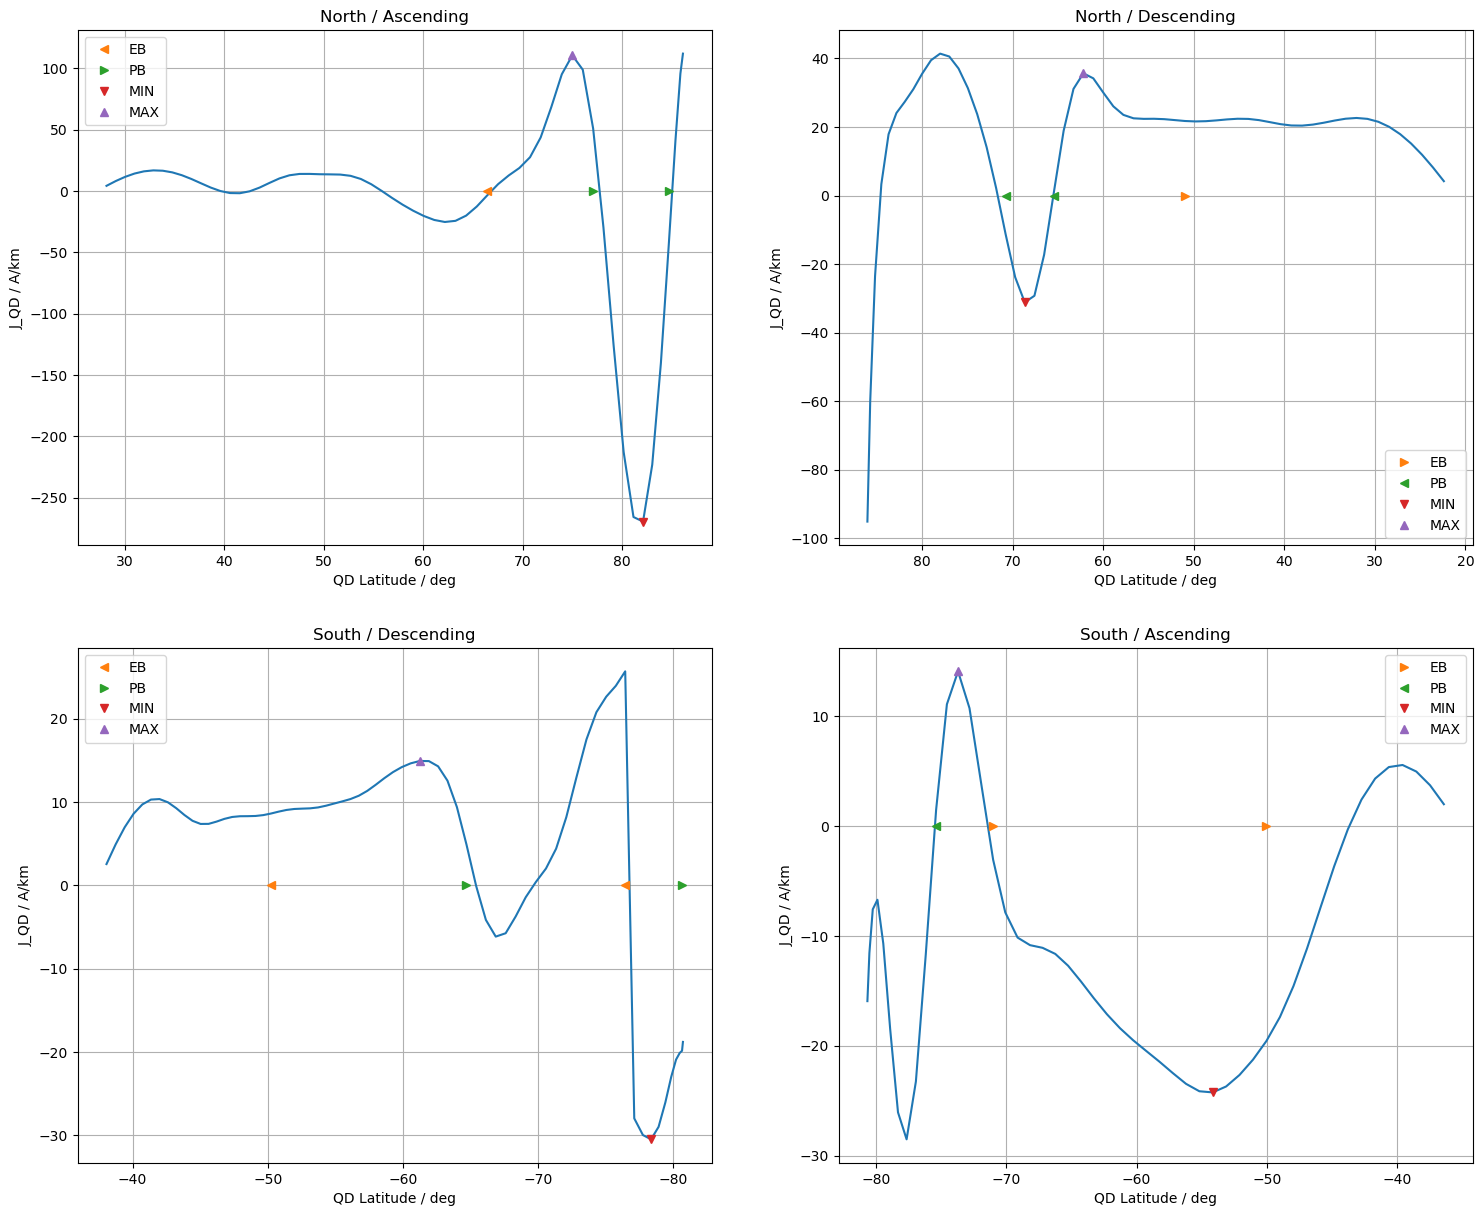

In [5]:
from numpy import isnan, logical_and
from matplotlib.pyplot import figure, subplot, show


def get_quadrant_mask(data, ascending, north):
    orbit_direction = data["QDOrbitDirection"][...]
    latitude = data["Latitude_QD"][...]
    return logical_and(
        (orbit_direction > 0 if ascending else orbit_direction < 0),
        (latitude > 0 if north else latitude < 0)
    )

def get_title(ascending, north):
    pass_ = "Ascending" if ascending else "Descending"
    hemisphere = "North" if north else "South"
    return "%s / %s" % (hemisphere, pass_)

# point types
EB0 = 0x0       # Equatorial Boundary 0 (WEJ?)
EB1 = 0x1       # Equatorial Boundary 1 (EEJ?)
PB0 = 0x2       # Polar Boundary 0 (WEJ?)
PB1 = 0x3       # Polar Boundary 1 (EEJ?)
PEAK_MIN = 0x4  # Peak - Minimum of J_QD
PEAK_MAX = 0x5  # Peak - Maximum of J_QD

def plot(ax, ascending, north):
    p_mask = get_quadrant_mask(profile, ascending=ascending, north=north)
    b_mask = get_quadrant_mask(boundaries, ascending=ascending, north=north)
    ax.plot(p_qd_latitude[p_mask], p_qd_j[p_mask])
    l_eb, = ax.plot(b_qd_latitude[b_mask&(point_type&0x6==0x0)], b_qd_j[b_mask&((point_type&0x6)==0x0)], '<' if north==ascending else '>')
    l_pb, = ax.plot(b_qd_latitude[b_mask&(point_type&0x6==0x2)], b_qd_j[b_mask&((point_type&0x6)==0x2)], '>' if north==ascending else '<')
    l_min, = ax.plot(b_qd_latitude[b_mask&(point_type==0x4)], b_qd_j[b_mask&(point_type==0x4)], 'v')
    l_max, = ax.plot(b_qd_latitude[b_mask&(point_type==0x5)], b_qd_j[b_mask&(point_type==0x5)], '^')
    if not ascending:
        xmin, xmax = ax.get_xlim(); ax.set_xlim((xmax, xmin)) # flip x axis
    ax.grid()
    ax.set_title(get_title(ascending=ascending, north=north))
    ax.set_xlabel('QD Latitude / deg')
    ax.set_ylabel('J_QD / A/km')
    ax.legend((l_eb, l_pb, l_min, l_max), ('EB', 'PB', 'MIN', 'MAX'))


p_qd_latitude = profile["Latitude_QD"][...]
p_qd_j = profile["J_QD"][...]

b_qd_latitude = boundaries["Latitude_QD"][...]
b_qd_j = boundaries["J_QD"][...]
b_qd_j[isnan(b_qd_j)] = 0
point_type = boundaries["PointType"]

fig = figure(figsize=(18, 15), dpi=100)
plot(subplot(221), ascending=True, north=True)
plot(subplot(222), ascending=False, north=True)
plot(subplot(223), ascending=False, north=False)
plot(subplot(224), ascending=True, north=False)